![cover](./images/analysis_cover.jpg)

# Microsoft Movie Analysis
Author: Jennifer Ha
***

## Overview
This analysis project explores trends in film business to provide Microsoft with actionable recommendations as they want to enter this business as well. we will review data sets from TheNumbers.com and IMDb to determine when Microsoft should release a movie, which types of genres to consider, and whom to recruit. The methodology includes filtering, and joining and visualizing data sets to show different trends in ROI. The result shows higher ROI when Mystery, Horror, and Animation movies are released in May-July, and November-December. I recommend Microsoft to partner with lists of top 10 actors and directors in those genres, and release movies during the summer (May-July) or holiday season (Nov-Dec).

## Business Problem

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies.
 
In order to assist the stakeholders at Microsoft to make data-driven decisions for their new business, we will be reviewing and analyzing datasets to provide a viable and profitable business option. The findings and recommendations will help the stakeholders with better understanding of the movie industry, to decide when to release their movies and who to work with to drive a successful outcome.


## Data
For this project, the following data sets from The Numbers and IMDb were used to answer the questions in the above. 
 
* `new_movie_budgets` & `tn_movie_budgets`: This data set from The Numbers contains movie production budget, domestic, and international revenue amount by movie, which will be used to conduct ROI analysis.
 
* `imdb_name_basics`: This data set from IMDb contains general movie information with movie title, runtime, and genre(s). Every movie has a unique ID (`tconst`) assigned, which will be used as the primary key to join other imdb data sets.
 
* `imdb_title_principals`: This data set from IMDb contains job titles for people who participated in a film with a unique ID (`nconst`) that can be used to identify individual participants. This data set also includes a foreign key (`tconst`).
 
* `imdb_title_basics`: This data set from IMDb contains names of individuals in the business with their profession title(s), movies they participated listed with the `tconst`, and their unique ID `nconst`.


### Prepare Data

In [1]:
#import libraries
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns

from scipy import stats

### Clean Up new_movie_budgets

In [2]:
new_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

new_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [3]:
#drop id since we don't need this column
new_movie_budgets = new_movie_budgets.drop('id', axis = 1)

#check data
new_movie_budgets

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
5777,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [4]:
#update the release_date column to include month only
new_movie_budgets['release_date'] = new_movie_budgets['release_date'].map(lambda x: '{}'.format(x[:4]))
new_movie_budgets

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Dec,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,May,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,Jun,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,May,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,Dec,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
5777,Dec,Red 11,"$7,000",$0,$0
5778,Apr,Following,"$6,000","$48,482","$240,495"
5779,Jul,Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,Sep,A Plague So Pleasant,"$1,400",$0,$0


In [5]:
#check for missing values
new_movie_budgets.isna().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [6]:
#convert currency with $ to integer
#code from https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas
new_movie_budgets[new_movie_budgets.columns[2:]] = new_movie_budgets[new_movie_budgets.columns[2:]].replace('[\$,]', '', regex=True).astype(int)

#check data
new_movie_budgets.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Dec,Avatar,425000000,760507625,2776345279
1,May,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,Jun,Dark Phoenix,350000000,42762350,149762350
3,May,Avengers: Age of Ultron,330600000,459005868,1403013963
4,Dec,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [7]:
#examine the data if there are any rows with value 0
print(len(new_movie_budgets[new_movie_budgets['production_budget'] > 0]) / len(new_movie_budgets))
print(len(new_movie_budgets[new_movie_budgets['domestic_gross'] > 0]) / len(new_movie_budgets))
print(len(new_movie_budgets[new_movie_budgets['worldwide_gross'] > 0]) / len(new_movie_budgets))

1.0
0.9052231061916292
0.936527153234175


In [8]:
#drop rows with value 0 in domestic_gross column since 90.5% of data have associated revenue values
new_movie_budgets = new_movie_budgets[new_movie_budgets['domestic_gross'] > 0]

#drop rows with value 0 in worldwide_gross column since 93.6% of data have associated revenue values
new_movie_budgets = new_movie_budgets[new_movie_budgets['worldwide_gross'] > 0]

#check data
new_movie_budgets

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,Dec,Avatar,425000000,760507625,2776345279
1,May,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,Jun,Dark Phoenix,350000000,42762350,149762350
3,May,Avengers: Age of Ultron,330600000,459005868,1403013963
4,Dec,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...
5775,May,Cavite,7000,70071,71644
5776,Dec,The Mongol King,7000,900,900
5778,Apr,Following,6000,48482,240495
5779,Jul,Return to the Land of Wonders,5000,1338,1338


In [9]:
#check the movie counts by month to ensure we have enough data points to compare
new_movie_budgets.value_counts('release_date', ascending = False )

release_date
Dec     550
Oct     530
Aug     467
Nov     456
Sep     455
Jun     450
Mar     427
Apr     423
Jul     416
May     382
Feb     361
Jan     317
dtype: int64

In [10]:
#group the DataFrame by release_month
movie_budgets_month = new_movie_budgets.groupby(by = ['release_date']).sum()

movie_budgets_month

,production_budget,domestic_gross,worldwide_gross
release_date,,,
Apr,10591650000,12407092932,27145936581
Aug,12431885719,15955429870,30230495155
Dec,22843697000,34345107925,74915227616
Feb,10725456247,13882543926,28029650527
Jan,7010271000,8310517342,16117881073
Jul,18605655975,26720337439,61986423180
Jun,20454553938,31531570976,68209786653
Mar,14187630848,18129303397,37793715705
May,18995094596,27146065077,65766464046


In [11]:
#calculate domestic ROI and worldwide ROI and add them to the DataFrame
def calculate_roi(budget, gross):
    return (gross - budget) / budget * 100
movie_budgets_month['domestic_roi'] = calculate_roi(movie_budgets_month['production_budget'], movie_budgets_month['domestic_gross'])
movie_budgets_month['worldwide_roi'] = calculate_roi(movie_budgets_month['production_budget'], movie_budgets_month['worldwide_gross'])

#check data
movie_budgets_month

,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
release_date,,,,,
Apr,10591650000,12407092932,27145936581,17.140322,156.295635
Aug,12431885719,15955429870,30230495155,28.342797,143.169024
Dec,22843697000,34345107925,74915227616,50.348290,227.947038
Feb,10725456247,13882543926,28029650527,29.435463,161.337605
Jan,7010271000,8310517342,16117881073,18.547733,129.918088
Jul,18605655975,26720337439,61986423180,43.614057,233.159031
Jun,20454553938,31531570976,68209786653,54.154283,233.469930
Mar,14187630848,18129303397,37793715705,27.782458,166.384967
May,18995094596,27146065077,65766464046,42.910923,246.228673


### Clean Up tn_movie_budgets

In [12]:
#import the tn_movie_budgets and examine the data
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

#get summary of the DataFrame
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [13]:
#drop id since we don't need this column, and domestic_gross column because we will focus on international ROI
tn_movie_budgets = tn_movie_budgets.drop(['id','domestic_gross'], axis = 1)

In [14]:
#convert release_date to datetime and add a release_year column
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['release_year'] = tn_movie_budgets['release_date'].dt.year

#check data
tn_movie_budgets

,release_date,movie,production_budget,worldwide_gross,release_year
0,2009-12-18,Avatar,"$425,000,000","$2,776,345,279",2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875",2011
2,2019-06-07,Dark Phoenix,"$350,000,000","$149,762,350",2019
3,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963",2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747",2017
...,...,...,...,...,...
5777,2018-12-31,Red 11,"$7,000",$0,2018
5778,1999-04-02,Following,"$6,000","$240,495",1999
5779,2005-07-13,Return to the Land of Wonders,"$5,000","$1,338",2005
5780,2015-09-29,A Plague So Pleasant,"$1,400",$0,2015


In [15]:
#check for missing values
tn_movie_budgets.isna().sum()

release_date         0
movie                0
production_budget    0
worldwide_gross      0
release_year         0
dtype: int64

In [16]:
#convert currency with $ to integer
#code from https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas
tn_movie_budgets[tn_movie_budgets.columns[2:]] = tn_movie_budgets[tn_movie_budgets.columns[2:]].replace('[\$,]', '', regex=True).astype(int)

#check data
tn_movie_budgets.head()

,release_date,movie,production_budget,worldwide_gross,release_year
0,2009-12-18,Avatar,425000000,2776345279,2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
2,2019-06-07,Dark Phoenix,350000000,149762350,2019
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017


In [17]:
#examine the data if there are any rows with value 0
print(len(tn_movie_budgets[tn_movie_budgets['production_budget'] > 0]) / len(tn_movie_budgets))
print(len(tn_movie_budgets[tn_movie_budgets['worldwide_gross'] > 0]) / len(tn_movie_budgets))

1.0
0.936527153234175


In [18]:
#drop rows with value 0 in worldwide_gross column since 93.6% of data have associated revenue values
tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['worldwide_gross'] > 0]

#check data
tn_movie_budgets.head()

,release_date,movie,production_budget,worldwide_gross,release_year
0,2009-12-18,Avatar,425000000,2776345279,2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
2,2019-06-07,Dark Phoenix,350000000,149762350,2019
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017


In [21]:
#calculate ROI and add the column in the DataFrame
def roi(budget, gross):
    return (gross - budget) / budget * 100
tn_movie_budgets['roi'] = roi(tn_movie_budgets['production_budget'], tn_movie_budgets['worldwide_gross'])

#check data
tn_movie_budgets

<ipython-input-21-cb28516fa4b6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_movie_budgets['roi'] = roi(tn_movie_budgets['production_budget'], tn_movie_budgets['worldwide_gross'])


,release_date,movie,production_budget,worldwide_gross,release_year,roi
0,2009-12-18,Avatar,425000000,2776345279,2009,553.257713
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011,154.667286
2,2019-06-07,Dark Phoenix,350000000,149762350,2019,-57.210757
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,2015,324.384139
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017,315.369636
...,...,...,...,...,...,...
5775,2006-05-26,Cavite,7000,71644,2006,923.485714
5776,2004-12-31,The Mongol King,7000,900,2004,-87.142857
5778,1999-04-02,Following,6000,240495,1999,3908.250000
5779,2005-07-13,Return to the Land of Wonders,5000,1338,2005,-73.240000


### Clean Up imdb_title_basics

In [22]:
#import the file and examine the data
imdb_title_basics = pd.read_csv("zippedData/imdb.title.basics.csv.gz")

imdb_title_basics

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN


In [23]:
#set tconst column as the index since it will be used as primary key when joining tables
imdb_title_basics = imdb_title_basics.set_index('tconst')

#check data
imdb_title_basics.head()

,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [24]:
#drop original_title and runtime_minutes columns as we don't need this data for our analysis
imdb_title_basics = imdb_title_basics.drop(['original_title','runtime_minutes'], axis = 1)

#check data
imdb_title_basics.head()

,primary_title,start_year,genres
tconst,,,
tt0063540,Sunghursh,2013,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama"
tt0069049,The Other Side of the Wind,2018,Drama
tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy"


In [25]:
#check for missing values
imdb_title_basics.isna().sum()

primary_title       0
start_year          0
genres           5408
dtype: int64

In [26]:
#examine genre column to determine whether we shoup drop N/As or replace them with 'Unknown'
imdb_title_basics['genres'].isna().sum()/len(imdb_title_basics)

0.037004598204510616

In [27]:
#drop rows with N/A in genres column since only 3.7% of data shows N/A
imdb_title_basics = imdb_title_basics.dropna(subset = ['genres'])

imdb_title_basics

,primary_title,start_year,genres
tconst,,,
tt0063540,Sunghursh,2013,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama"
tt0069049,The Other Side of the Wind,2018,Drama
tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy"
...,...,...,...
tt9916428,The Secret of China,2019,"Adventure,History,War"
tt9916538,Kuambil Lagi Hatiku,2019,Drama
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,Documentary


In [28]:
#convert genres to list
imdb_title_basics['genres'] = imdb_title_basics['genres'].map(lambda x: x.split(','))

#check data
imdb_title_basics

,primary_title,start_year,genres
tconst,,,
tt0063540,Sunghursh,2013,"[Action, Crime, Drama]"
tt0066787,One Day Before the Rainy Season,2019,"[Biography, Drama]"
tt0069049,The Other Side of the Wind,2018,[Drama]
tt0069204,Sabse Bada Sukh,2018,"[Comedy, Drama]"
tt0100275,The Wandering Soap Opera,2017,"[Comedy, Drama, Fantasy]"
...,...,...,...
tt9916428,The Secret of China,2019,"[Adventure, History, War]"
tt9916538,Kuambil Lagi Hatiku,2019,[Drama]
tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,[Documentary]


### Clean Up imdb_title_principals

In [29]:
#import the file and examine the data
imdb_title_principals = pd.read_csv("zippedData/imdb.title.principals.csv.gz")

imdb_title_principals

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


In [30]:
#set tconst column as the index since it will be used as primary key/foreign key when joining tables
imdb_title_principals = imdb_title_principals.set_index('tconst')

#check data
imdb_title_principals.head()

,ordering,nconst,category,job,characters
tconst,,,,,
tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
tt0111414,2,nm0398271,director,NaN,NaN
tt0111414,3,nm3739909,producer,producer,NaN
tt0323808,10,nm0059247,editor,NaN,NaN
tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [31]:
#drop ordering, job, and characters columns as we don't need this data for our analysis
imdb_title_principals = imdb_title_principals.drop(['ordering','job','characters'], axis = 1)

#check data
imdb_title_principals.head()

,nconst,category
tconst,,
tt0111414,nm0246005,actor
tt0111414,nm0398271,director
tt0111414,nm3739909,producer
tt0323808,nm0059247,editor
tt0323808,nm3579312,actress


In [32]:
#check for missing values
imdb_title_principals.isna().sum()

nconst      0
category    0
dtype: int64

In [33]:
#examine the job titles and value counts in category column
imdb_title_principals.category.value_counts()

actor                  256718
director               146393
actress                146208
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65424
editor                  55512
production_designer      9373
archive_footage          3307
archive_sound              16
Name: category, dtype: int64

In [34]:
#replace 'actress' with 'actors' 
imdb_title_principals['category'] = imdb_title_principals.category.str.replace('actress','actor')

#check if 'actress' is replaced with 'actor'
imdb_title_principals['category'].unique()

array(['actor', 'director', 'producer', 'editor', 'composer',
       'cinematographer', 'writer', 'self', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

### Clean Up imdb_name_basics

In [35]:
#import the file and examine the data
imdb_name_basics = pd.read_csv("zippedData/imdb.name.basics.csv.gz")

imdb_name_basics

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress,NaN
606644,nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
606645,nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer,NaN


In [36]:
#set nconst column as the index since it will be used as primary key/foreign key when joining tables
imdb_name_basics = imdb_name_basics.set_index('nconst')

#check data
imdb_name_basics.head()

,primary_name,birth_year,death_year,primary_profession,known_for_titles
nconst,,,,,
nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [37]:
#drop birth_year, death_year, primary_profession, and 'known_for_titles' as we don't need this data for our analysis
imdb_name_basics = imdb_name_basics.drop(['birth_year','death_year','primary_profession','known_for_titles'], axis = 1)

#check data
imdb_name_basics

,primary_name
nconst,
nm0061671,Mary Ellen Bauder
nm0061865,Joseph Bauer
nm0062070,Bruce Baum
nm0062195,Axel Baumann
nm0062798,Pete Baxter
...,...
nm9990381,Susan Grobes
nm9990690,Joo Yeon So
nm9991320,Madeline Smith


## Join Datasets

### Merge tn_movie_budgets and imdb_title_basics as df

Combine `tn_movie_budget` and `imdb_title_basics` DataFrame to create a new DataFrame called `df`. Since the column names are different, we are going to explicitly mention both the column names using 'left_on' and 'right_on' arguments. 

In [38]:
#merge tn_movie_budgets and imdb_title_basics as df
df = pd.merge(imdb_title_basics.reset_index(), tn_movie_budgets,
             left_on=['primary_title', 'start_year'],
             right_on=['movie', 'release_year'])

#drop duplicate columns (primary_title, start_year)
df = df.drop(['primary_title','start_year'], axis = 1)

#reset index to tconst
df = df.set_index('tconst')

#check data
df

,genres,release_date,movie,production_budget,worldwide_gross,release_year,roi
tconst,,,,,,,
tt0249516,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0359950,"[Adventure, Comedy, Drama]",2013-12-25,The Secret Life of Walter Mitty,91000000,187861183,2013,106.440860
tt0365907,"[Action, Crime, Drama]",2014-09-19,A Walk Among the Tombstones,28000000,62108587,2014,121.816382
tt0369610,"[Action, Adventure, Sci-Fi]",2015-06-12,Jurassic World,215000000,1648854864,2015,666.909239
tt0376136,"[Comedy, Drama]",2011-10-28,The Rum Diary,45000000,21544732,2011,-52.122818
...,...,...,...,...,...,...,...
tt7959026,"[Crime, Drama, Thriller]",2018-12-14,The Mule,50000000,170857676,2018,241.715352
tt8043306,"[Action, Comedy, Crime]",2018-07-20,Teefa in Trouble,1500000,98806,2018,-93.412933
tt8155288,"[Drama, Horror, Mystery]",2019-02-13,Happy Death Day 2U,9000000,64179495,2019,613.105500


In [39]:
#check for duplicates since df DataFrame will serve as our primary table for future analysis. 
df[df.duplicated(
        subset = ['movie', 'release_year'],
        keep = False)].shape

(94, 7)

Remove the duplicate columns as a result of the merge. 

In [40]:
#drop duplicates
df = df[~df.duplicated(
        subset = ['movie', 'release_year'],
        keep=False)]

#check data
df

,genres,release_date,movie,production_budget,worldwide_gross,release_year,roi
tconst,,,,,,,
tt0249516,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0359950,"[Adventure, Comedy, Drama]",2013-12-25,The Secret Life of Walter Mitty,91000000,187861183,2013,106.440860
tt0365907,"[Action, Crime, Drama]",2014-09-19,A Walk Among the Tombstones,28000000,62108587,2014,121.816382
tt0369610,"[Action, Adventure, Sci-Fi]",2015-06-12,Jurassic World,215000000,1648854864,2015,666.909239
tt0376136,"[Comedy, Drama]",2011-10-28,The Rum Diary,45000000,21544732,2011,-52.122818
...,...,...,...,...,...,...,...
tt7959026,"[Crime, Drama, Thriller]",2018-12-14,The Mule,50000000,170857676,2018,241.715352
tt8043306,"[Action, Comedy, Crime]",2018-07-20,Teefa in Trouble,1500000,98806,2018,-93.412933
tt8155288,"[Drama, Horror, Mystery]",2019-02-13,Happy Death Day 2U,9000000,64179495,2019,613.105500


### Join df with imdb_title_principals

Update the `df` DataFrame by joining `imdb_title_principals` using an inner join, and the output will automatically drop N/A values. There is no need to specify where the join will occur since we have already reset indices for this purpose when cleaning the data.

In [41]:
#join df with imdb_title_principals
df = imdb_title_principals.join(df, how='inner')

df

,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,roi
tconst,,,,,,,,,
tt0249516,nm0257258,producer,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0249516,nm0240381,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0249516,nm0240380,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0249516,nm0000221,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0249516,nm0519456,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
...,...,...,...,...,...,...,...,...,...
tt9024106,nm0465484,director,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683
tt9024106,nm0813301,director,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683
tt9024106,nm2445956,producer,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683


In [42]:
#Check for people who appears more than once in a movie
df.reset_index().duplicated(subset=['tconst', 'nconst']).sum()

0

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13144 entries, tt0249516 to tt9024106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   nconst             13144 non-null  object        
 1   category           13144 non-null  object        
 2   genres             13144 non-null  object        
 3   release_date       13144 non-null  datetime64[ns]
 4   movie              13144 non-null  object        
 5   production_budget  13144 non-null  int64         
 6   worldwide_gross    13144 non-null  int64         
 7   release_year       13144 non-null  int64         
 8   roi                13144 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 1.0+ MB


### Join df with imbd_name_basics

In [44]:
df = pd.merge(df.reset_index(),imdb_name_basics,how = 'inner', on = 'nconst')

df

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,roi,primary_name
0,tt0249516,nm0257258,producer,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman
1,tt0249516,nm0240381,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff
2,tt0249516,nm0240380,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Haylie Duff
3,tt0249516,nm0000221,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Charlie Sheen
4,tt0249516,nm0519456,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Eva Longoria
...,...,...,...,...,...,...,...,...,...,...,...
13139,tt9024106,nm0478750,actor,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Robia Scott
13140,tt9024106,nm5237225,actor,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Jared Lotz
13141,tt9024106,nm2445956,producer,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Chris Jones
13142,tt9024106,nm7839151,producer,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Joe Knopp


## Split Genres to Separate Rows

Use `explode` function to transform each element in a list in 'genres' column. This will allow us to easily run analysis by `genres`.

In [45]:
df = df.explode('genres')
df

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,roi,primary_name
0,tt0249516,nm0257258,producer,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman
0,tt0249516,nm0257258,producer,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman
0,tt0249516,nm0257258,producer,Comedy,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman
1,tt0249516,nm0240381,actor,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff
1,tt0249516,nm0240381,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff
...,...,...,...,...,...,...,...,...,...,...,...
13141,tt9024106,nm2445956,producer,Drama,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Chris Jones
13142,tt9024106,nm7839151,producer,Biography,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Joe Knopp
13142,tt9024106,nm7839151,producer,Drama,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Joe Knopp
13143,tt9024106,nm0498920,producer,Biography,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Daryl C. Lefever


## Identify and Remove Outliers

We have now completed cleaning up and joining the DataFrames that are required for this project. However, we need to further examine the data before we start data exploration to check if there are any outliers that should be removed.

First, we will examine the overall production_budget against ROI, and will create a fucntion so that we can re-visualize the data after removing the outliers.

In [46]:
#define a function to visualize scatter plots with outliers
def scatter_plot(df, x ='production_budget', y = 'roi'):
    
    #create the plot 
    f, ax = plt.subplots(figsize = (10,7))

    #generate a scatter plot
    ax.scatter(data = df,
           x = 'production_budget', 
           y= 'roi')

    #add labels for x and y axes
    ax.set_xlabel('Production Budget', labelpad = 20, size = 13)
    ax.set_ylabel('ROI', labelpad = 20, size = 13)

    #add a title for the plot
    ax.set_title('Production Budget vs. ROI', size = 15)
    ;

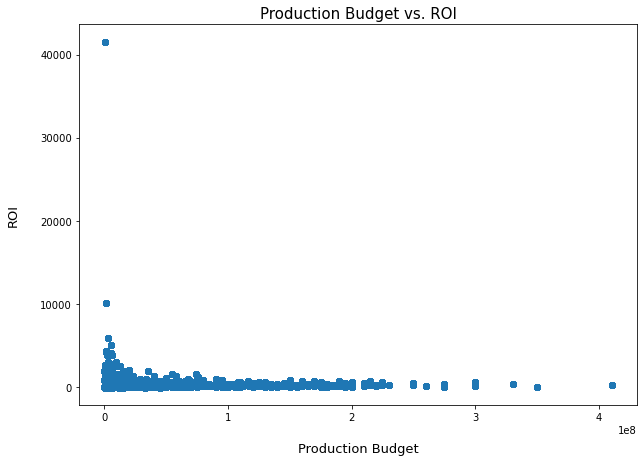

In [47]:
scatter_plot(df)

### Z Score Method
Using a [z-score method](https://www.ctspedia.org/do/view/CTSpedia/OutLier#:~:text=Any%20z%2Dscore%20greater%20than,standard%20deviations%20from%20the%20mean.&text=Thus%20the%20z%2Dscore%20when,%2D%200.6549541%2F0.4165770%20%3D%203.228805.), we will clean up the data by removing data points with z-score greater than 3. For this project, we can ignore checking data points with z-score less than 3 because ROI cannot be less than -100%.

In [48]:
#calculate z-score on ROI and create a new column to show the z-score in the DataFrame
df['roi_zscore'] = stats.zscore(df['roi'])

#remove rows with z-score greater than 3
df = df[df['roi_zscore'] < 3]



df

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,roi,primary_name,roi_zscore
0,tt0249516,nm0257258,producer,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
0,tt0249516,nm0257258,producer,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
0,tt0249516,nm0257258,producer,Comedy,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
1,tt0249516,nm0240381,actor,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff,-0.300732
1,tt0249516,nm0240381,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff,-0.300732
...,...,...,...,...,...,...,...,...,...,...,...,...
13141,tt9024106,nm2445956,producer,Drama,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Chris Jones,-0.073205
13142,tt9024106,nm7839151,producer,Biography,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Joe Knopp,-0.073205
13142,tt9024106,nm7839151,producer,Drama,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Joe Knopp,-0.073205
13143,tt9024106,nm0498920,producer,Biography,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Daryl C. Lefever,-0.073205


Now, vusualize the updated DataFrame after removing rows with z-score greater 3.

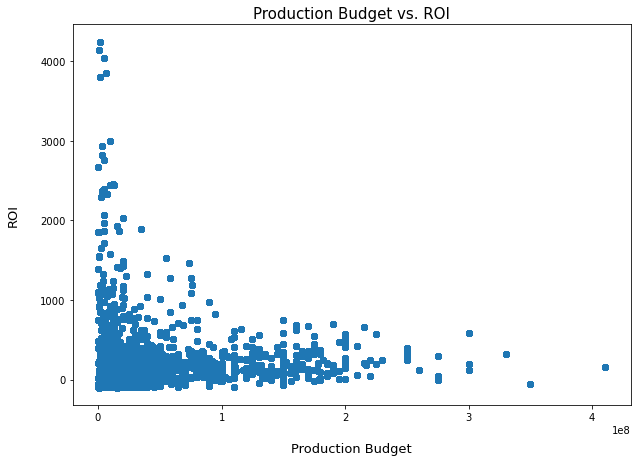

In [49]:
scatter_plot(df)

The scatter plot looks so much better! Now that we have cleaned up the overall DataFrame with z-score calculation on ROI, let's plot a box plot and take a look at ROI by genre.

In [50]:
#define a function to visualize box plots with outliers
def box_plot(df, x ='genres', y = 'roi'):
    
    #create the plot 
    f, ax = plt.subplots(figsize = (15,7))

    #generate a box plot
    sns.boxplot(data = df,
           x = 'genres', 
           y= 'roi',
           showfliers = True)
    
    #add labels for x and y axes
    ax.set_xlabel('Genre', labelpad = 20, size = 13)
    ax.set_ylabel('ROI', labelpad = 20, size = 13)

    #add a title for the plot
    ax.set_title('ROI by Genre', pad = 20, size = 15)
    
    plt.xticks(rotation = 45)

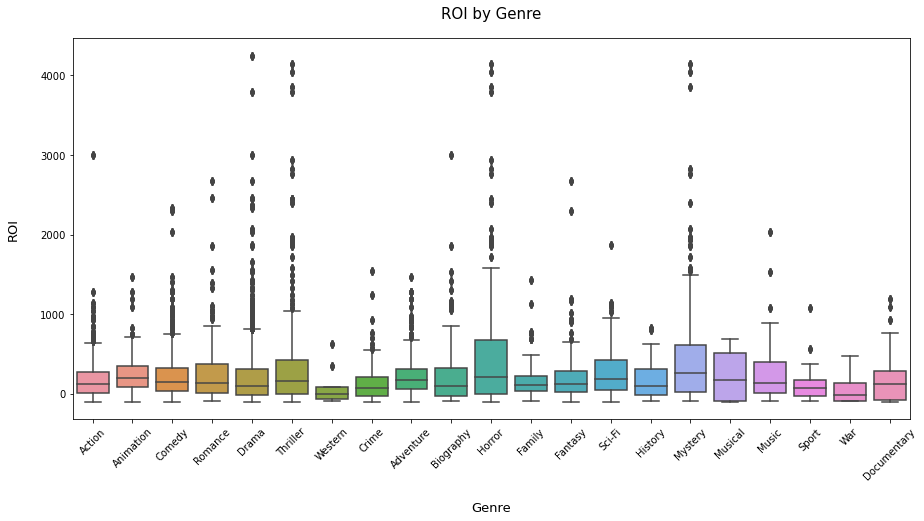

In [51]:
box_plot(df)

Even though we removed  outliers using the z-score method, the box plot still shows that not all genres have the symmetric distribution. Therefore, we will use median ROI values when analyzing top 3 most profitable genres.

## Analysis

### Question 1: When is the best time of year to release a movie?
Not only do we want to produce movies in profitable genres, we also want to aim for the best timing to release a movie. Let's figure out when would be the best time of year to do so.

First, prepare the DataFrame that we cleaned up for this analysis.

In [52]:
movie_budgets_month

,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
release_date,,,,,
Apr,10591650000,12407092932,27145936581,17.140322,156.295635
Aug,12431885719,15955429870,30230495155,28.342797,143.169024
Dec,22843697000,34345107925,74915227616,50.348290,227.947038
Feb,10725456247,13882543926,28029650527,29.435463,161.337605
Jan,7010271000,8310517342,16117881073,18.547733,129.918088
Jul,18605655975,26720337439,61986423180,43.614057,233.159031
Jun,20454553938,31531570976,68209786653,54.154283,233.469930
Mar,14187630848,18129303397,37793715705,27.782458,166.384967
May,18995094596,27146065077,65766464046,42.910923,246.228673


''

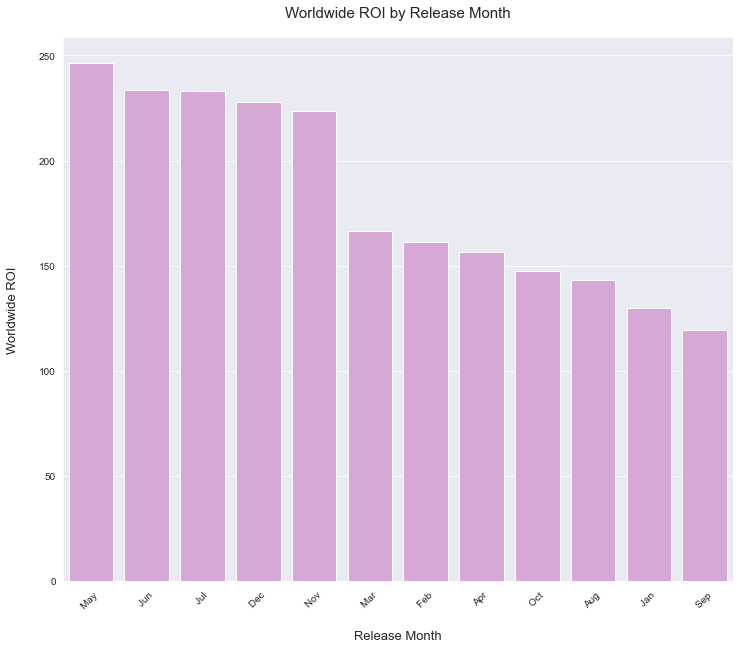

In [53]:
#create a new DataFrame to sort bars in descending order
worldwide_roi_month = movie_budgets_month.sort_values('worldwide_roi', ascending = False)

#Plotting the graph


plt.figure(figsize=(12,10))

sns.set_style('darkgrid')

fig = sns.barplot(x = worldwide_roi_month.index, 
                  y = worldwide_roi_month['worldwide_roi'], 
                  data = worldwide_roi_month,
                  color='plum')

plt.title("Worldwide ROI by Release Month", size = 15, pad = 20) 

plt.xlabel("Release Month", size = 13, labelpad = 20)
plt.ylabel("Worldwide ROI", size = 13, labelpad = 20)


plt.xticks(rotation=45)
;

''

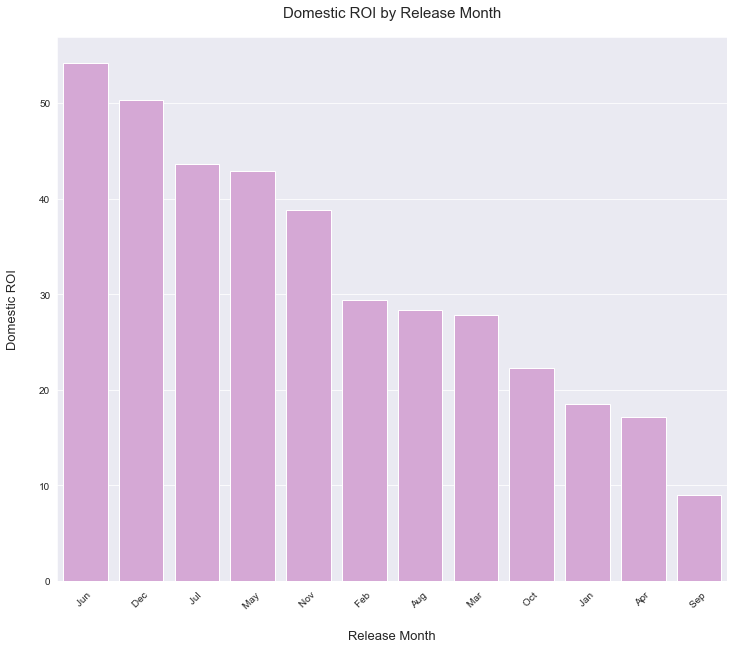

In [54]:
#create a new DataFrame to sort bars in descending order
domestic_roi_month = movie_budgets_month.sort_values('domestic_roi', ascending = False)

#Plotting the graph

plt.figure(figsize=(12,10))

sns.set_style('darkgrid')

fig = sns.barplot(x = domestic_roi_month.index, 
                  y = domestic_roi_month['domestic_roi'],
                  data = domestic_roi_month,
                  color='plum')

plt.title("Domestic ROI by Release Month", size = 15, pad = 20) 

plt.xlabel("Release Month", size = 13, labelpad = 20)
plt.ylabel("Domestic ROI", size = 13, labelpad = 20)


plt.xticks(rotation=45)
;

#### Release movies in May, June, July, November, or December!
Domestically and internationally, we see the highest ROI in May, June, July, November, December. Such trend tells us that people are more willing to go watch a movie during the summertime and holiday seasons towards the end of year. 

### Question 2: Which genres are the most profitable and yield the highest ROI?
To answer this question, we want to make sure we have accurate movie counts in each genre. Therefore, we need to clean up the data again because genres by movie are showing up more than once due to multiple individuals/roles in a movie.

In [55]:
#remove duplicate genres by movie
df_genres = df[~df.duplicated(subset=['tconst', 'genres'])]

df_genres

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,roi,primary_name,roi_zscore
0,tt0249516,nm0257258,producer,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
0,tt0249516,nm0257258,producer,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
0,tt0249516,nm0257258,producer,Comedy,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
5,tt1563742,nm0519456,actor,Comedy,2018-05-04,Overboard,12000000,85369830,2018,611.415250,Eva Longoria,0.235783
5,tt1563742,nm0519456,actor,Romance,2018-05-04,Overboard,12000000,85369830,2018,611.415250,Eva Longoria,0.235783
...,...,...,...,...,...,...,...,...,...,...,...,...
13095,tt7535780,nm3414570,actor,Documentary,2017-02-17,The Great Wall,150000000,334486852,2017,122.991235,Nicolette Creighton,-0.132648
13114,tt8043306,nm9590185,cinematographer,Action,2018-07-20,Teefa in Trouble,1500000,98806,2018,-93.412933,Zain Haleem,-0.295887
13114,tt8043306,nm9590185,cinematographer,Comedy,2018-07-20,Teefa in Trouble,1500000,98806,2018,-93.412933,Zain Haleem,-0.295887
13114,tt8043306,nm9590185,cinematographer,Crime,2018-07-20,Teefa in Trouble,1500000,98806,2018,-93.412933,Zain Haleem,-0.295887


As discussed, let's review median ROI by genre for this exercise. We will focus on median ROI rather than average ROI because some genres were showing skewed distributions in the box plot.

In [56]:
#calculate median ROI by genre 
median_ROI_genre = df_genres[['genres','roi']].groupby('genres').median()

#sort data
median_ROI_genre = median_ROI_genre.sort_values(by = 'roi', ascending = False)

#check data
median_ROI_genre

,roi
genres,
Mystery,257.317468
Horror,203.703704
Animation,199.921813
Sci-Fi,177.831032
Musical,173.752303
Adventure,167.114096
Thriller,154.963578
Comedy,148.168133
Romance,136.969703


We will drop genres with negative median ROI values since our goal is to successfully generate profit on this new business!

In [57]:
#drop genres with negative median ROI values
median_ROI_genre = median_ROI_genre[median_ROI_genre['roi'] > 0]

#check data
median_ROI_genre

,roi
genres,
Mystery,257.317468
Horror,203.703704
Animation,199.921813
Sci-Fi,177.831032
Musical,173.752303
Adventure,167.114096
Thriller,154.963578
Comedy,148.168133
Romance,136.969703


Now let's plot the data.

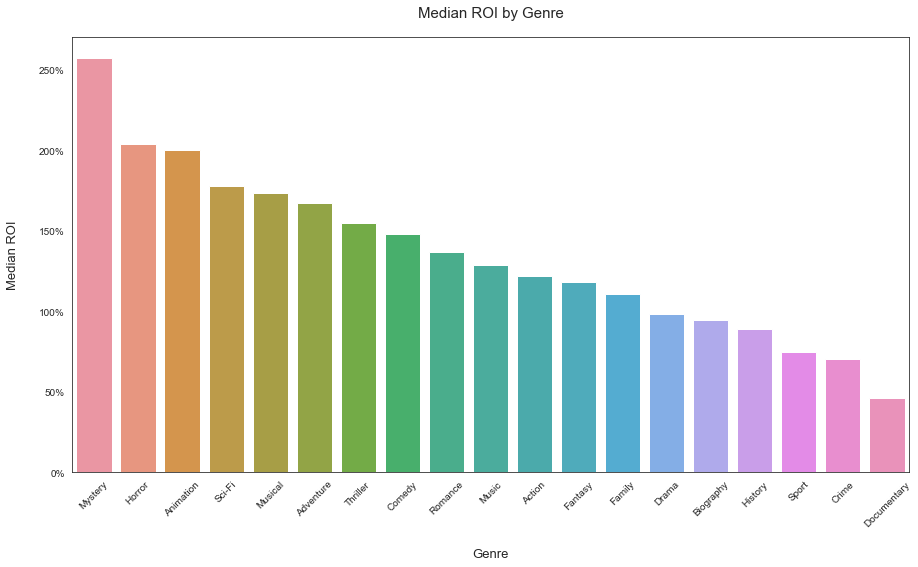

In [58]:
sns.set_style('white')

#create the plot
fig, ax = plt.subplots(figsize = (15, 8))

#Generate a bar graph
ax = sns.barplot(x = median_ROI_genre.index, 
                 y = median_ROI_genre['roi'])

#add a title for the plot
plt.title('Median ROI by Genre', fontsize = 15, pad = 20)

#add labels for x and y axes
plt.xlabel('Genre', fontsize = 13, labelpad = 20)
plt.ylabel('Median ROI', fontsize = 13, labelpad =20)

#rotate x-ticks
plt.xticks(rotation = 45)

#add % to y-labels
ax.yaxis.set_major_formatter(mtick.PercentFormatter())


#### Mystery, Horror, Animation win!
I advise the stakeholders at Microsoft to consider producing movies in Mystery, Horror, Animation genres.

### Question 3: Who are the top casts and directors in those genres that Microsoft should work with?

In [59]:
#filter data for top 3 genres
df_people = df[df['genres'].isin(['Mystery','Horror','Animation'])]

df_people

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,roi,primary_name,roi_zscore
0,tt0249516,nm0257258,producer,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
1,tt0249516,nm0240381,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff,-0.300732
2,tt0249516,nm0240380,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Haylie Duff,-0.300732
3,tt0249516,nm0000221,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Charlie Sheen,-0.300732
4,tt0249516,nm0519456,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Eva Longoria,-0.300732
...,...,...,...,...,...,...,...,...,...,...,...,...
13108,tt7784604,nm2715764,composer,Mystery,2018-06-08,Hereditary,10000000,70133905,2018,601.339050,Colin Stetson,0.228182
13124,tt8155288,nm3015807,editor,Horror,2019-02-13,Happy Death Day 2U,9000000,64179495,2019,613.105500,Ben Baudhuin,0.237058
13124,tt8155288,nm3015807,editor,Mystery,2019-02-13,Happy Death Day 2U,9000000,64179495,2019,613.105500,Ben Baudhuin,0.237058
13125,tt8155288,nm7059572,actor,Horror,2019-02-13,Happy Death Day 2U,9000000,64179495,2019,613.105500,Phi Vu,0.237058


In [60]:
#check for duplicates
df_people[df_people.duplicated(
        subset = ['category','genres','movie','primary_name'],
        keep = False)].shape

(0, 12)

In [61]:
#update the DataFrame to include coloumns that we need for analysis
df_people_new = df_people[['nconst','category','genres','production_budget','worldwide_gross','primary_name']]

df_people_new

,nconst,category,genres,production_budget,worldwide_gross,primary_name
0,nm0257258,producer,Animation,45000000,73706,Robert Engelman
1,nm0240381,actor,Animation,45000000,73706,Hilary Duff
2,nm0240380,actor,Animation,45000000,73706,Haylie Duff
3,nm0000221,actor,Animation,45000000,73706,Charlie Sheen
4,nm0519456,actor,Animation,45000000,73706,Eva Longoria
...,...,...,...,...,...,...
13108,nm2715764,composer,Mystery,10000000,70133905,Colin Stetson
13124,nm3015807,editor,Horror,9000000,64179495,Ben Baudhuin
13124,nm3015807,editor,Mystery,9000000,64179495,Ben Baudhuin
13125,nm7059572,actor,Horror,9000000,64179495,Phi Vu


In [62]:
#group the columns to get the total production budget & worldwide gross revenue by person, genre, and category
df_people_grouped = df_people_new.groupby(by = ['nconst','primary_name','genres','category']).sum()

df_people_grouped

production_budget  \
nconst    primary_name               genres    category                      
nm0000092 John Cleese                Animation actor              30000000   
                                               writer            135000000   
nm0000093 Brad Pitt                  Animation actor             130000000   
                                     Horror    actor             190000000   
nm0000098 Jennifer Aniston           Animation actor              70000000   
...                                                                    ...   
nm9133740 Huck Milner                Animation actor             200000000   
nm9204083 Ole Kirk Christiansen      Animation writer             60000000   
nm9204084 Godtfred Kirk Christiansen Animation writer             60000000   
nm9827373 Ian Cooper                 Horror    producer           20000000   
                                     Mystery   producer           20000000   

                                                         worldwide_gross  
nconst    primary_name               genres    category                   
nm0000092 John Cleese                Animation actor            50145607  
                                               writer          573068425  
nm0000093 Brad Pitt                  Animation actor           321887208  
                                     Horror    actor           531514650  
nm0000098 Jennifer Aniston           Animation actor           183353431  
...                                                                  ...  
nm9133740 Huck Milner                Animation actor          1242520711  
nm9204083 Ole Kirk Christiansen      Animation writer          457729388  
nm9204084 Godtfred Kirk Christiansen Animation writer          457729388  
nm9827373 Ian Cooper                 Horror    producer        254210310  
                                     Mystery   producer        254210310  

[2882 rows x 2 columns]

In [63]:
#calculate the ROI
def roi(budget, gross):
    return (gross - budget) / budget * 100
df_people_grouped['ROI'] = roi(df_people_grouped['production_budget'], df_people_grouped['worldwide_gross'])

#reset index
df_people_grouped.reset_index(inplace = True)

df_people_grouped

,nconst,primary_name,genres,category,production_budget,worldwide_gross,ROI
0,nm0000092,John Cleese,Animation,actor,30000000,50145607,67.152023
1,nm0000092,John Cleese,Animation,writer,135000000,573068425,324.495130
2,nm0000093,Brad Pitt,Animation,actor,130000000,321887208,147.605545
3,nm0000093,Brad Pitt,Horror,actor,190000000,531514650,179.744553
4,nm0000098,Jennifer Aniston,Animation,actor,70000000,183353431,161.933473
...,...,...,...,...,...,...,...
2877,nm9133740,Huck Milner,Animation,actor,200000000,1242520711,521.260356
2878,nm9204083,Ole Kirk Christiansen,Animation,writer,60000000,457729388,662.882313
2879,nm9204084,Godtfred Kirk Christiansen,Animation,writer,60000000,457729388,662.882313
2880,nm9827373,Ian Cooper,Horror,producer,20000000,254210310,1171.051550


In [64]:
#reusable function to show top 10 individuals by genre
def plot_ppl_roi_cat(df, genre, category, n = 10):
    
    #filter for genre
    df = df[df['genres'] == genre]
    
    #filter for categy
    df = df[df['category'] == category]
    
    #sort by ROI
    df = df.sort_values(by = 'ROI', ascending = False)
    
    #create a list of individuals so we can limit to a number of individuals
    nconsts = df['nconst'].unique()
    
    #limit to number of people
    df = df[df['nconst'].isin(nconsts[:n])]
    
    # =plot the figure
    sns.set_style('darkgrid')
    plt.figure (figsize = (15, 10))
    ax = sns.barplot(data = df,
                y = 'primary_name',
                x = 'ROI')
    
    #add a title for the plot            
    plt.title('Top 10 ' + category.title() + 's in ' + genre + ' Movies', fontsize = 15, pad = 20)
    
    
    # add and adjust labels
    ax.set_xlabel('ROI', fontsize = 13, labelpad = 20)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(labelsize = 12)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

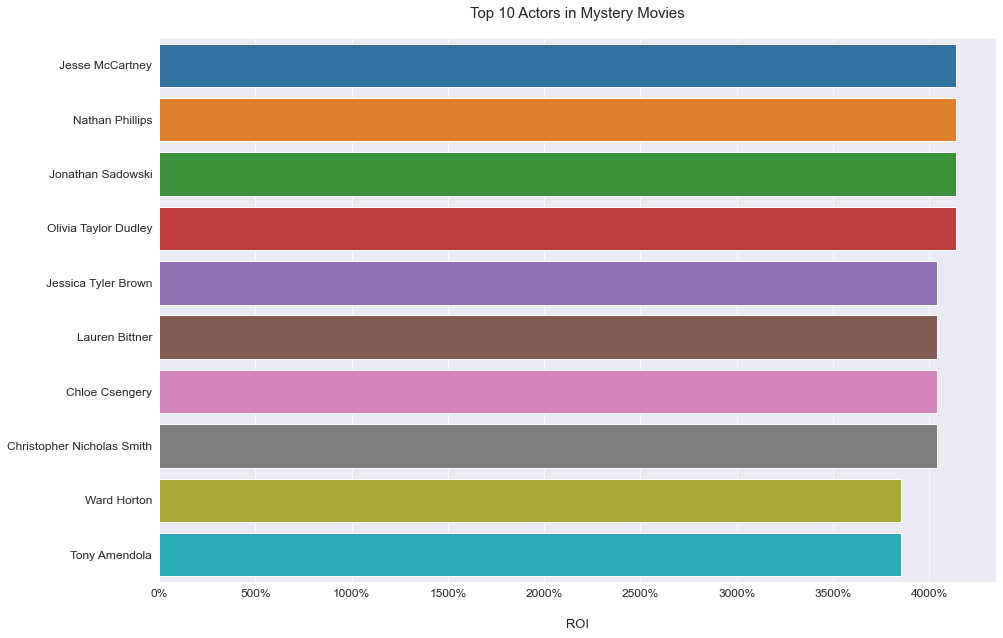

In [65]:
plot_ppl_roi_cat(df_people_grouped, 'Mystery', 'actor')

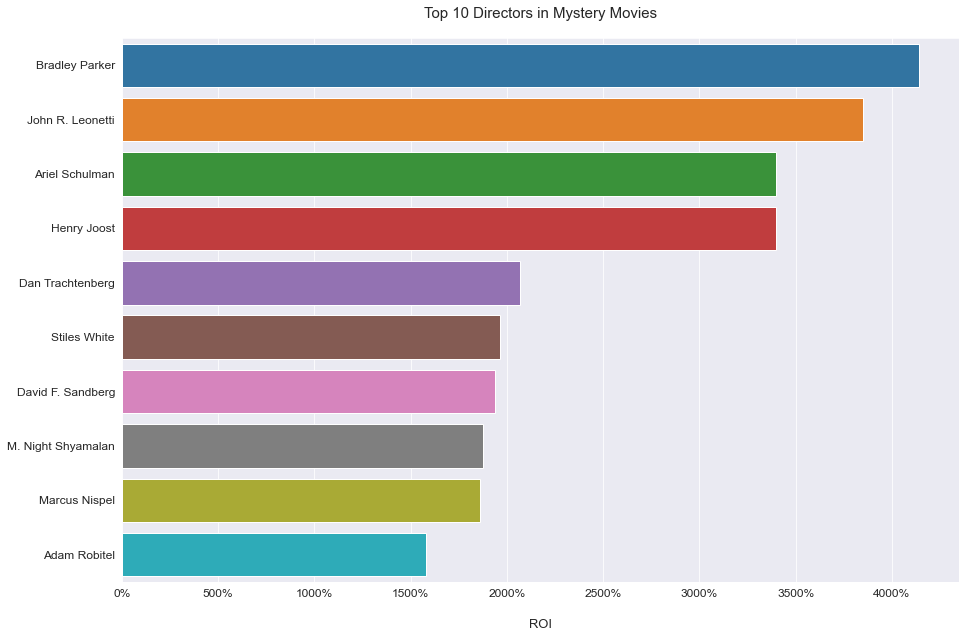

In [66]:
plot_ppl_roi_cat(df_people_grouped, 'Mystery', 'director')

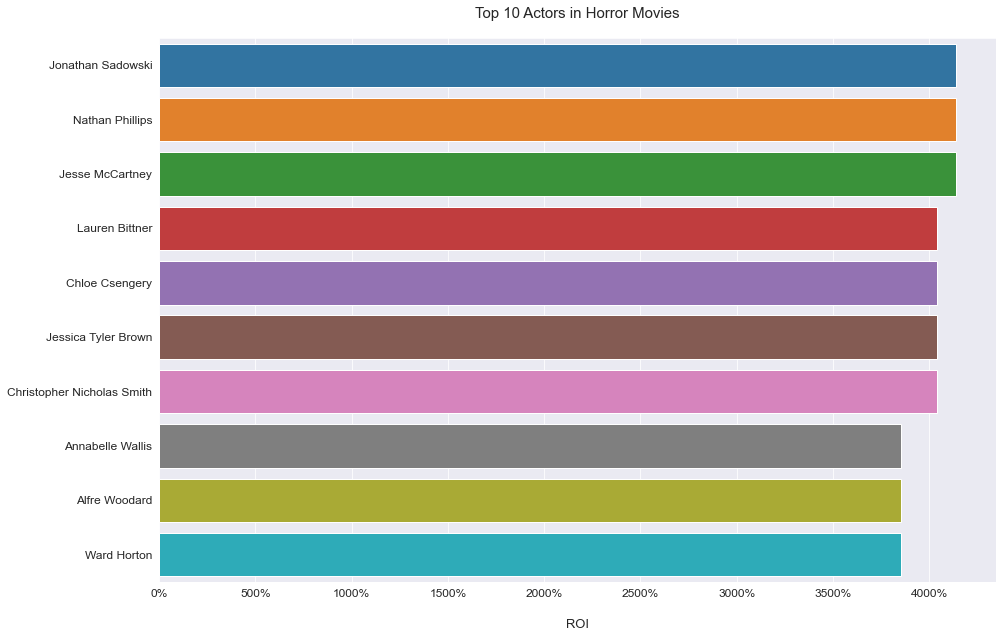

In [67]:
plot_ppl_roi_cat(df_people_grouped, 'Horror', 'actor')

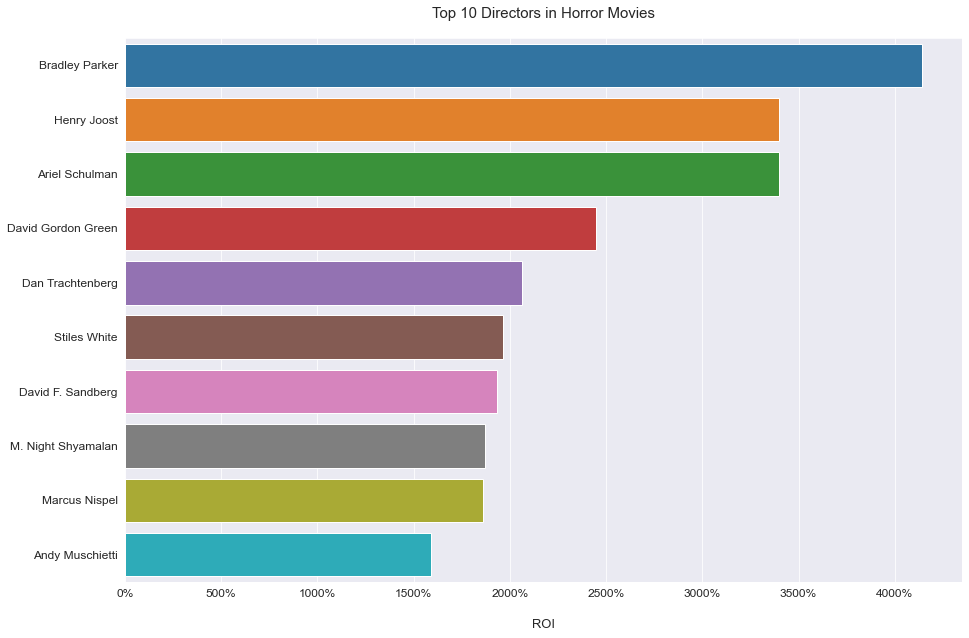

In [68]:
plot_ppl_roi_cat(df_people_grouped, 'Horror', 'director')

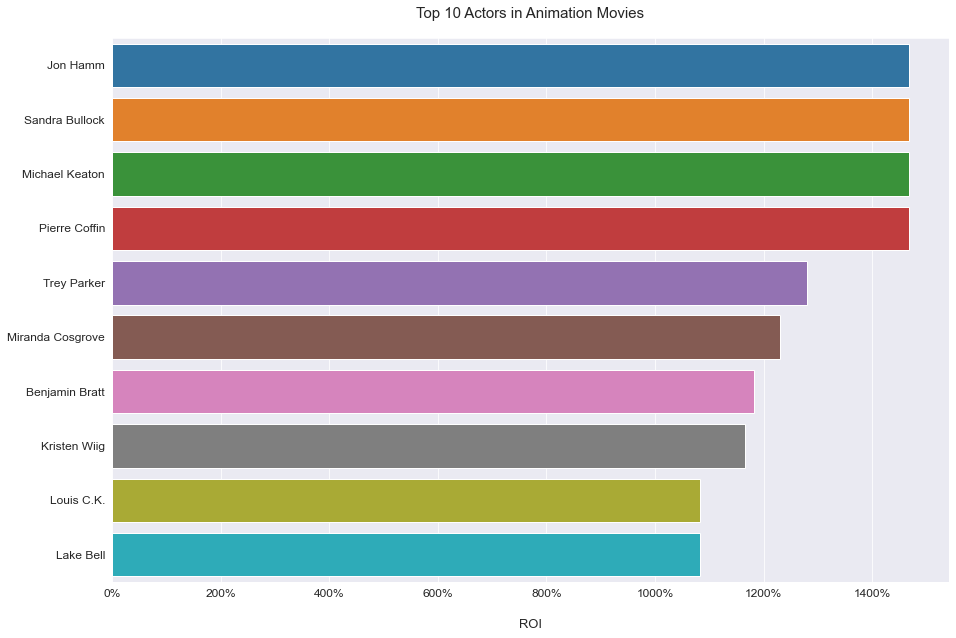

In [69]:
plot_ppl_roi_cat(df_people_grouped, 'Animation', 'actor')

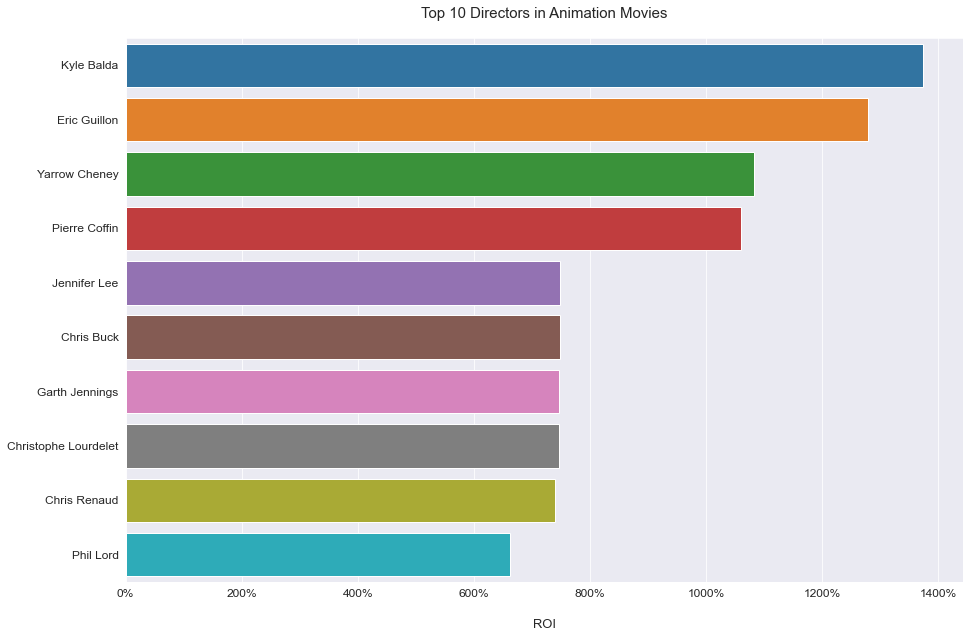

In [70]:
plot_ppl_roi_cat(df_people_grouped, 'Animation', 'director')

#### Let's recruit people!
This analysis provides Microsoft with lists of actors and directors who were part of most successful movies in Mystery, Horror, and Animation. Microsoft should consider working with these individuals in order to enter the movie industry with "big hit" movies.

## Conclusions
This analysis leads to three recommendations for creating movies :

**1. Release movies in May, June, July, November, or December.** Our analysis shows that summertime and holiday seasons are the best time of year to release a movie. If Microsoft wants to release a movie across the world simultaneously, I recommend launching a movie in June or July. If different timeline can be applied, release a movie in the States in May first, then internationally in June.

**2. Produce a movie in Mystery, Horror, Animation genres.** Microsoft has the capability to run movie business in many countries as it has many locations worldwide. Therefore, I recommend producing a movie in Mystery, Horror, and Animation to target audience globally.

**3. Recruit people with proven stats.** I provided lists of top 10 actors and directors in top 3 genres that generated the most profit. Microsoft should contact these individuals and try to recruit them to enter this competitive movie industry.

## Next Steps
Further analyses could lead to additional insights:
* **ROI Trend in Popular Genres**: while we have identified which top 3 genres have generated the most profit, such analysis can provide whether the business is continuously growing in those genres over time.
* **Ideal Budget Range**: This modeling could predict the ideal production budget for the movies that Microsoft wants to produce.